In [1]:
legi: "19-747-096"

# SLT-CE-4: Constant Shift Embedding

## Task

Many real-world phenomena are described by pairwise proximity data, modeling interactions between the entities of the system. This in contrast to the more common situation where each data sample is given as a feature vector. Even though the clustering of the proximity data may be performed directly on the data matrix, there are some advantatages of  embedding the data into a vector space. For example, it enables the use of some standard preprocessing techniques such as denoising or dimensionality reduction. In this coding exercise, we will explore the tecnhique called _Constant Shift Embedding_ for restating pairwise clustering problems in vector spaces [1] while preserving the cluster structure. We will apply the algorithm described in [1] to cluster the groups of research community members based on the email correspondence matrix. The data and its description is given in [2].

### References 

[1] [Optimal cluster preserving embedding of nonmetric proximity data](https://ieeexplore.ieee.org/document/1251147)

[2] [email-Eu-core](https://snap.stanford.edu/data/email-Eu-core.html)

 <h2 style="background-color:#f0b375;"> Setup </h2>

We start by importing necessary python packages.

In [2]:
import numpy as np
import sklearn as skl
import matplotlib.pylab as plt
import pylab
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans

import scipy.linalg as la
import scipy.sparse.csgraph as csgraph
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

# Fix randoom seed for reproducibility
np.random.seed(42)

The number of nodes is hardcoded for simplicity (taken from [2]):

In [3]:
NUM_NODES = 1005

We load the file which contains the list of interactions between the community members (nodes). Our data matrix represents an undirected graph which connects two nodes if there was at least one email sent between the two corresponding community members. Thus our data matrix is essentially an adjacency matrix.

In [4]:
# initialize data matrix which will be an adjacency matrix
DATA = np.zeros((NUM_NODES, NUM_NODES))

# fill out the symmetric adjacency matrix
with open("email-Eu-core.txt") as file:
    for line in file:
        pair = [int(x) for x in line.split()]
        DATA[pair[0], pair[1]] = 1
        DATA[pair[1], pair[0]] = 1

Note that DATA specifies an adjacency matrix of the email graph. It's not claimed to be a proper dissimilarity matrix required by CSE algorithm. So, you are allowed to perform any manipulations to construct a suitable (dis-)similarity matrix for the further analysis.

Next we define a class which contains main functionalities - TO BE IMPLEMENTED.

In [5]:
print(np.unique(DATA, return_counts=True))

(array([0., 1.]), array([977255,  32770]))


In [55]:

class ConstantShiftEmbedding(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for Constant Shift Embedding (CSE)
    
    Attributes:
        PMAT (np.ndarray): Proximity matrix used for calculating the embeddings.
        S (np.ndarray): Similarity matrix.
        D (np.ndarray): Dissimilarity matrix.
        
    """
    
    def __init__(self):
        self.PMAT = None
        self.S = None
        self.D = None
        # Add/change parameters, if necessary.
        self.S_tilde_c = None
        # need also S_c as it was used in Figure 4 of [1]
        self.S_c = None
        self.D_tilde_c = None
    
    def fit(self, PMAT):
        """ Calculate similarity/dissimiliarity matrix and all
        the necessary variables for calculating the embeddings.
        
        Args:
            PMAT (np.ndarray): proximity matrix
        """

        # Save data
        self.PMAT = PMAT
        
        ## IMPLEMENT THIS METHOD
        # see: https://math.stackexchange.com/questions/724158/shortest-distance-matrix-given-an-adjacency-matrix
        self.D = csgraph.shortest_path(DATA, directed=False, unweighted=True)
        # if there is no path between two nodes, the distance is infinite; thus have to replace it with a large number
        print(self.D[self.D != np.inf].max()) # 7
        self.D[self.D == np.inf] = self.D[self.D!=np.inf].max() + 5.0
        
        # symmetrize if it is not symmetric 
        # (should already be symmeteric as underlying adjacency matrix is symmetric)
        if not np.all(self.D == self.D.T): # check if D is symmetric
            D_s = 0.5 * (self.D + self.D.T)
        else:
            D_s = self.D
        
        # centralize dissimilarity matrix; note that self.D.shape[0] is the same as NUM_NODES
        I_n = np.eye(self.D.shape[0])
        e_n = np.ones((self.D.shape[0], 1))
        Q = I_n - 1 / self.D.shape[0] * e_n @ e_n.T
        D_c = Q @ D_s @ Q
        
        assert D_c.sum(axis=0).sum() < 1e-10, "D_c is not centered"
        assert D_c.sum(axis=1).sum() < 1e-10, "D_c is not centered"
        
        # compute Gram matrix:
        self.S_c = -0.5 * D_c
        # compute minimum eigenvalue of S_c
        # note that due to the symmetry of S_c, we can use eigh instead of eigs
        # eigh alsao orders the eigenvalues in ascending order by default:
        eigenvalues = la.eigvalsh(self.S_c)
        min_eigenvalue = eigenvalues[0]
        
        # as in [1], we can use D̃ = D_symm - 2 * λ_n(S_c) * (e_n * e_n^T - I_n)
        D_tilde = D_s - 2 * min_eigenvalue * (e_n @ e_n.T - I_n)
        self.D_tilde_c = Q @ D_tilde @ Q
        
        # compute Gram matrix:
        self.S_tilde_c = -0.5 * self.D_tilde_c
        
        
        
        
    def get_embedded_vectors(self, p):
        """Return embeddings
        
        Args:
            p (np.ndarray): cut-off value in eigenspectrum
        
        Returns:
            Xp (np.ndarray): embedded vectors
        
        """
        
        ## IMPLEMENT THIS METHOD
        # sorting the eigenvalues:
        # see: https://stackoverflow.com/questions/8092920/sort-eigenvalues-and-associated-eigenvectors-after-using-numpy-linalg-eig-in-pyt
        eigenvalues, eigenvectors = la.eigh(self.S_tilde_c)
        indices = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[indices]
        eigenvectors = eigenvectors[:, indices]
        
        # extract first p eigenvalues and eigenvectors
        V_p = eigenvectors[:, :p]
        Lambda_p = np.diag(eigenvalues)[:p]
        
        X_p = V_p @ np.sqrt(Lambda_p)
        
        return X_p


<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">Describe briefly and consicely the model given in [1]. Explain the main steps of _Constant Shift Embedding_ algorithm. See <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">markdown cheatsheet</a> for text editing.</p>

- **Constant Shift Embedding**: (Put your answer here)


<p style="background-color:#adebad;">
    Implement Constant Shift Embedding. We start off by making an instance of the corresponding class.
</p>    

In [56]:
CSE = ConstantShiftEmbedding()

<p style="background-color:#adebad;">
    Fit the data matrix. _fit(...)_ method computes necessary variables which can be later on used to produce embeddings [1].
</p>    

In [57]:
CSE.fit(DATA)

7.0


<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
    Next, try to find approximately optimal $p = p^∗$, a cut-off value which removes noise from the data. To do that, produce an eigen-spectrum plot as shown in [1] figure 4a and briefly explain your choice of $p^∗$.
</p>

In [58]:
## Compute eigen-spectrum
eigen_spectrum = np.linalg.eigvalsh(CSE.S_c)[::-1]
eigen_spectrum_change = eigen_spectrum[:-1] - eigen_spectrum[1:]

In [59]:
## Determine a good cut-off value (and write some lines to explain your choice)
p_opt = 15 ## change accordingly
print("Chosen cut-off value is: ", p_opt)

Chosen cut-off value is:  15


First, note that the eigenvalues are influenced by our choice of the fill value of the infinite entries in the data matrix that occur due to some nodes not being connected. I used a large number (self.D[self.D == np.inf] = self.D[self.D!=np.inf].max() + 5.0; this evaluates to 12.0) to fill the infinite entries. Hence, my choice of $p^∗$ most likely is different from the one you get when using a different fill value.

Having said that, based on the eigen-spectrum plot, I identified the optimal $p^∗$ as the point where the eigenvalues start to decrease rapidly (i.e. the elbow point). That is, I chose $p^*$ to be 15 due to the sudden drop in the change of eigen-spectrum after the 15-th eigenvalue.

Text(0, 0.5, 'Change of Eigenvalue (Scale Limited to 2)')

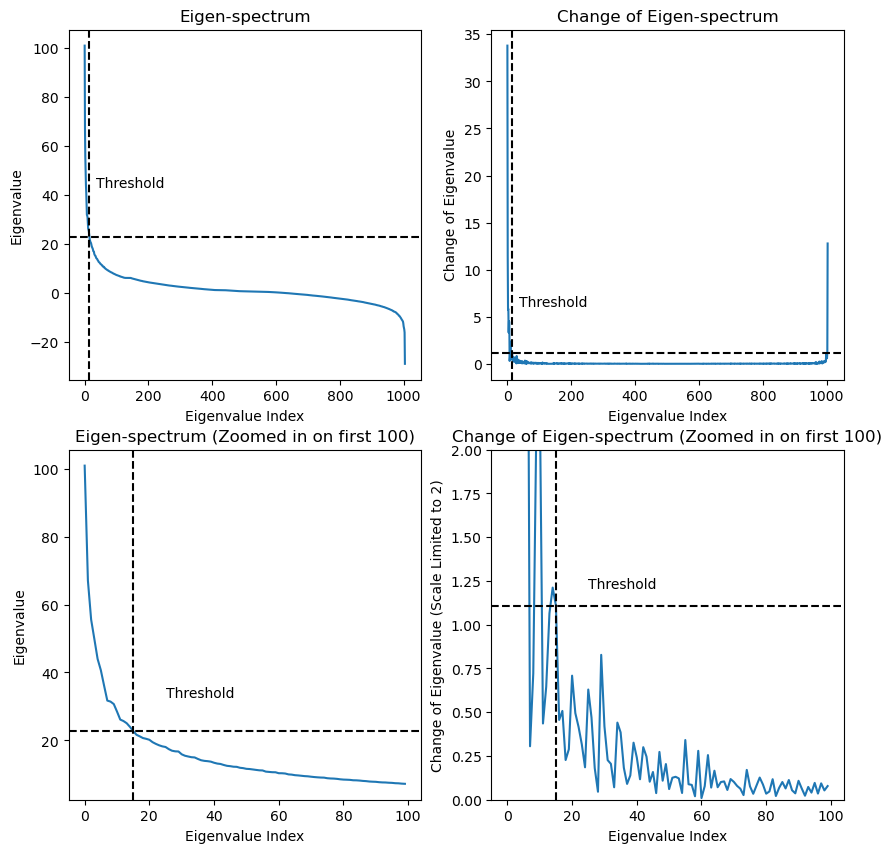

In [60]:
## Plot spectrum and indicate the cut-off value on the spectrum
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].plot(eigen_spectrum, linestyle = "-")
ax[0, 0].axvline(x = p_opt, color = "black", linestyle = "--")
ax[0, 0].annotate("Threshold", (p_opt + 20, eigen_spectrum[p_opt] + 20))
ax[0, 0].axhline(y = eigen_spectrum[p_opt], color = "black", linestyle = "--")
ax[0, 0].set_title("Eigen-spectrum")
ax[0, 0].set_xlabel("Eigenvalue Index")
ax[0, 0].set_ylabel("Eigenvalue")

ax[0, 1].plot(eigen_spectrum_change, '-')
ax[0, 1].axvline(x = p_opt, color = "black", linestyle = "--")
ax[0, 1].annotate("Threshold", (p_opt + 20, eigen_spectrum_change[p_opt] + 5))
ax[0, 1].axhline(y = eigen_spectrum_change[p_opt], color = "black", linestyle = "--")
ax[0, 1].set_title("Change of Eigen-spectrum")
ax[0, 1].set_xlabel("Eigenvalue Index")
ax[0, 1].set_ylabel("Change of Eigenvalue")

ax[1, 0].plot(eigen_spectrum[:100], '-')
ax[1, 0].axvline(x = p_opt, color = "black", linestyle = "--")
ax[1, 0].annotate("Threshold", (p_opt + 10, eigen_spectrum[p_opt] + 10))
ax[1, 0].axhline(y = eigen_spectrum[p_opt], color = "black", linestyle = "--")
ax[1, 0].set_title("Eigen-spectrum (Zoomed in on first 100)")
ax[1, 0].set_xlabel("Eigenvalue Index")
ax[1, 0].set_ylabel("Eigenvalue")

ax[1, 1].set_ylim(0, 2)
ax[1, 1].plot(eigen_spectrum_change[:100], '-')
ax[1, 1].axvline(x = p_opt, color = "black", linestyle = "--")
ax[1, 1].annotate("Threshold", (p_opt + 10, eigen_spectrum_change[p_opt] + 0.1))
ax[1, 1].axhline(y = eigen_spectrum_change[p_opt], color = "black", linestyle = "--")
ax[1, 1].set_title("Change of Eigen-spectrum (Zoomed in on first 100)")
ax[1, 1].set_xlabel("Eigenvalue Index")
ax[1, 1].set_ylabel("Change of Eigenvalue (Scale Limited to 2)")

<h2 style="background-color:#f0b375;">
Section 5.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.0 </span>
</h2>

<p style="background-color:#adebad;">
    Plot the distance matrices both for the denoised ($p = p^*$ -- from the previous step) and the original versions as shown in figure 5 in [1]. Note that the distance matrix is a matrix with pairwise distances between every two points from the dataset ($d_{ij} = dist(x_i, x_j)$).<br>
    Perform K-MEANS algorithm for varying number of clusters K on the embedded vectors derrived from CSE. You may use the sklearn implementation of K-MEANS. To make the aforementioned plots meaningful, sort the nodes according to the cluster belongings for every number of clusters K (see the figure 5). For now, there is no need to include the actual ground truth labels given in [2].
</p>

In [69]:
## Distance matrices
X_p_opt = CSE.get_embedded_vectors(p_opt)

In [37]:
preds = KMeans(n_clusters=8, random_state=42).fit_predict(X_p_opt)

/home/janhsc/miniconda3/envs/slt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [42]:
preds = clusters.predict(X_p)

In [47]:
centroids = clusters.cluster_centers_

In [79]:
kmeans = KMeans(n_clusters=10)
clusters = kmeans.fit_predict(CSE.D_tilde_c)

# Reorder the distance matrix by clusters
indices = np.argsort(clusters)
reordered_matrix = CSE.D_tilde_c[indices, :][:, indices]
reordered_matrix -= reordered_matrix.min()
reordered_matrix = np.log(reordered_matrix)

/home/janhsc/miniconda3/envs/slt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/tmp/ipykernel_341261/3933355683.py:8: RuntimeWarning: divide by zero encountered in log
  reordered_matrix = np.log(reordered_matrix)


In [80]:
reordered_matrix

array([[-29.58218521,   4.25098129,   4.25098129, ...,   4.37528895,
          4.37378519,   4.36897052],
       [  4.25098129, -28.94033133,   4.25098129, ...,   4.37528895,
          4.37378519,   4.36897052],
       [  4.25098129,   4.25098129, -29.1767201 , ...,   4.37528895,
          4.37378519,   4.36897052],
       ...,
       [  4.37528895,   4.37528895,   4.37528895, ...,   2.92193042,
          4.37741541,   4.37261822],
       [  4.37378519,   4.37378519,   4.37378519, ...,   4.37741541,
          2.90899223,   4.37111044],
       [  4.36897052,   4.36897052,   4.36897052, ...,   4.37261822,
          4.37111044,   2.86654113]])

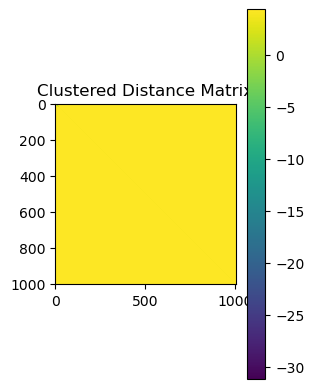

In [81]:
plt.subplot(1, 2, 2)
plt.imshow(reordered_matrix, cmap='viridis')
plt.title('Clustered Distance Matrix')
plt.colorbar()
plt.show()

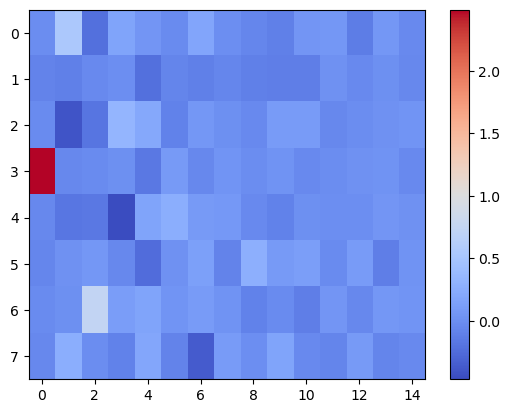

In [48]:
plt.imshow(centroids, aspect='auto', cmap='coolwarm')
plt.colorbar()

<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<p style="background-color:#adebad;">
    Producing 2D and 3D embeddings allows us to nicely visualize generated clusters. Now calculate the embeddings for p = 2 (2D case) and p = 3 (3D case) and plot clusterings for a few values of K.  Alternatively, you could use $p = p^*$ for more gentle denoising, cluster the denoised embeddings and only then apply a dimensionality reduction technique to get a plot in 2,3-dimensional space. You could use PCA, LLE, t-SNE etc. figure out what works for you. As an example see figure 6 (b) from [1] where CSE is combined with PCA.
</p>

In [13]:
## Get embeddings, run K-MEANS and generate plots

In [14]:
## p = 2

In [15]:
## p = 3

In [16]:
## choose p > 3, for example, p = p_opt, to compute CSE embeddings 
## First, cluster the computed p-dimentional embeddings and then project them onto 2-dimensional space 
## for visualization using PCA, LL, t-SNE or something else

<h2 style="background-color:#f0b375;">
Section 6.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<p style="background-color:#adebad;">
Finally, to evaluate the quality of the above derived clusters, let's compare our predictions with the ground truth. We will use the actual member-institution mappings given in [2]. You can reuse code from the previous coding exercises to align the cluster labels with the ground truth.
</p>

In [17]:
# Initialize community members affeliation array
AFFILIATIONS = np.zeros((NUM_NODES, ))

# Fill out the affiliation array
with open("email-Eu-core-department-labels.txt") as file:
    for line in file:
        pair = [int(x) for x in line.split()]
        AFFILIATIONS[pair[0]] = pair[1]

# Number of organizations is 
print("The true number of clusters (departments) is: ",len(np.unique(AFFILIATIONS)))

The true number of clusters (departments) is:  42


<p style="background-color:#adebad;">
Visually or quantitatively, in a clever and convincing way, show that the K-MEANS generated clusters overlap with the ground truth clusters (member affiliations). How can we measure the overlapping of the predicted and true clusters?
</p>

In [18]:
## Here you can provide plots and calculations

Please, write here your explanations, observation and thoughts about results of the experiments above.

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.